(### WARNING ### - do not use 2021-01-18_trySaturated.ipynb! It uses an older SaturationStacker pre bugfixes. Use this notebook instead.)

## Started 2021-03-24 - try assessing the saturation levels for a range of opsims ##

**2021-03-24** - copied from saturationstacker notebook. Started refactoring steps into a method that can be called each time through. Still under construction - **warning** this won't yet work on sciserver due to differences in the directory structure from Datalab.

**2021-03-24 9pm:** TODOS:

* ~Implement filter lists~ DONE - now scales saturation and faint target magnitudes from r-band apparent magnitude.
* ~look into weighting by nstars (probably nstars in r-band)~ DONE - either stardensity or trilegal can be used (though - at least on Datalab - Trilegal requires rotation from galactic to equatorial. That's dealt with below.)

In [1]:
# 2021-01-17 - try to run PY's new saturation stacker
#
# 2021-02-18 UPDATED with the corrected saturation stacker (there was a bug in the original).
# This new saturation stacker is in the github sims_maf (and was pasted here). When Datalab's
# version is updated to have this stacker, I will remove the corresponding cell in this notebook.
#
# THis is all pasted from a prototype notebook Peter Yoachim produced in response to queries.
#
# Updated with some syntax to find the dynamic range between the median saturation limit in the 
# short exposures and the coadded m5 depth in the long exposures. If there are no short exposures
# in the opsim, then the saturation limit is taken from the long exposures. If there are no long
# exposures then the m5 depth is taken from the short exposures. "Short" and "Long" are defined as 
# having total visit time less than or above timeCut = 20 seconds.

In [2]:
# import python pieces
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db


In [3]:
# top level directory for opsim databases
#
# on sciserver
# dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  

# on datalab
dbroot='/sims_maf/fbs_1.5/short_exp/'

In [4]:
# for making a new metricBundle
import copy

In [5]:
# import lsst-relevant stuff
import lsst.sims.maf.stackers as stackers

In [6]:
# 2021-02-28 This is the saturation stacker written and bugfixed by Peter Yoachim. Pasted here until
# the updated stacker is available on Datalab and on Sciserver. If rerunning the entire notebook, 
# you will probably need to restart and clear outputs beforehand.
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
    Parameters
    ----------
    pixscale : float, opt (0.2)
        Arcsec per pixel
    gain : float, opt (2.3)
        electrons per adu
    saturation_e : float, opt (150e3)
        The saturation level in electrons
    zeropoints : dict-like, opt (None)
        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
        If None, will use Rubin-like zeropoints.
    km : dict-like, opt (None)
        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        names = ['u', 'g', 'r', 'i', 'z', 'y']
        types = [float]*6
        if zeropoints is None:
            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
            self.saturation_adu = saturation_e 
        else:
            self.zeropoints = zeropoints

        if km is None:
            # Also from notebook above
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            # Calculate the length of the on-sky time per EXPOSURE
            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            # Total sky counts in each exposure 
            sky_counts = sky_counts * exptime
            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = simData[self.seeingCol][in_filt]/2.354
            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
            # source counts = counts per exposure (expTimeCol / nexp)
            # Translate to counts per second, to apply zeropoint 
            count_rate = source_counts / exptime
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

        return simData

In [7]:
def selectBrightnessKeys(bg=None, keySat='saturation_mag', keyDepth='CoaddM5'):
    
    """Determine which keys in the bundle dict to use for our 'short' and 'long' exposures"""

    # if a bundle group was not passed in, return dummy keywords that will fail later on.
    if bg is None:
        return 'DUMMY_sat', 'DUMMY_m5'
    
    # Below, we will use the saturation limit and the m5 limiting depth from the 
    # short or long exposures as appropriate. 
    #
    # which keys we use depends on whether there actually *were* "short" as 
    # well as "long" exposures in the opsim. There's probably a sims_maf-ish way 
    # to learn this, but for the moment we just determine which does not have 
    # "None" as the metricValues. We first learn which keys correspond to the 
    # pieces we want, then find out which are populated.

    # These dictionaries are keyed by the search terms in the bundle names.
    # For clarity let's just use one dictionary each for the saturation mag
    # and for the m5 magnitude keys. Doing things this way should allow us 
    # to make changes to the search string up above (e.g. by varying the 
    # filter) and everything from here down should be unaffected.
    keySats = {'lt':'DUMMY', 'gt':'DUMMY'}
    keyMags = {'lt':'DUMMY', 'gt':'DUMMY'}

    # Look for keys that have "lt" and "saturation_mag"
    for sKey in bg.bundleDict.keys():
        for sSz in keySats.keys():
            if sKey.find(sSz) > -1:
                if sKey.find(keySat) > -1:
                    keySats[sSz] = sKey[:]
                if sKey.find(keyDepth) > -1:
                    keyMags[sSz] = sKey[:]

    # Default bundles to use: short exp for saturation and long exp for m5 depth
    keySatUse = keySats['lt'][:]
    keyM5Use = keyMags['gt'][:]

    # If the short-exposure bundle has no metricValues, switch to the long-exposure
    if bg.bundleDict[keySatUse].metricValues is None:
        keySatUse = keySats['gt'][:]

    # if the long-exposure bundle has no metricValues, switch to the short-exposure
    if bg.bundleDict[keyM5Use].metricValues is None:
        keyM5Use = keyMags['lt'][:]
        
    return keySatUse, keyM5Use

In [8]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# need a different set of utils for the stellarmags
import lsst.sims.utils as sims_utils

In [9]:
## set the run name for this time round
#run_path = 'short_exp_5ns_5expt_v1.5_10yrs.db'
#run_name = run_path.split('/')[-1].split('_v')[0]

In [10]:
## Connect to the database (on sciserver)
## dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  # now selected farther up
## conn = db.OpsimDatabase(dbroot+run_path)  # whoops - redundant. Commented out.
# outDir = 'satur_test'
#resultsDb = db.ResultsDb(outDir=outDir)
#nside = 64 

#timeCut=20.
#sFilter = 'r'

In [11]:
def evaluateBundleGroup(pathOpsim='DUMMY', outDir='satur_test', nside=64, timeCut=20., sFilter='r', \
                  doPlots=True, run_name=''):
    
    """Creates and evaluates the bundle group for a particular run"""
    
    ## Refactored from various cells in this notebook
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1].split('_v')[0]
        
    print("####### INFO - run name:", run_name)
    
    bundleList = []
    
    # declare a few things
    stacker = SaturationStacker()
    metric = metrics.MedianMetric(col='saturation_mag')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [metrics.MedianMetric()]
    plotDict = {}
    plotFuncs = [plots.HealpixSkyMap()]
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
    sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))

    sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup
    return bg
    

In [12]:
## This cell is useful to find out what paths are present.
## ldum = glob.glob('/sims_maf/*/twi*_neo/*db')
# ldum

In [322]:
# import stellar density map - helps when scaling by nstars. This and the following cell thanks to pointers
# from Xialong Li, UDel
from lsst.utils import getPackageDir

def loadStarDens(sfilt='r', nside=64, wdstars='', trilegal=False, dustonly=False):
    
    """Loads the stellar density maps. nside not equal to 64 will only work if those paths exist on the system.
    
    For star maps, use wdstars='_wdstars' to retrieve white dwarfs"""
    
    # trilegal is now sent in as a boolean (so that we can use the same boolean when calling other
    # routines to reorder trilegal if necessary)
    
    # 2021-03-25 (WIC) - I'm not clear whether Trilegal maps actually work the way I think they do - the 
    # mollview looks a little stripey. Perhaps Trilegal is nested and starmaps isn't, or vice versa?
    # To be revisited...
    
    # This at least supports getting the contents of star maps from different subdirectories.
    mapDir = getPackageDir('sims_maps')
    
    # We'll use glob to search for file paths matching the search string. This might be 
    # overkill (since at the moment the search strings ARE the paths we want) but it does
    # ensure we either get a readable path or no path.
    
    # search string for the map file. Default to starmaps.
    subdir='StarMaps'
    srchTail = 'starDensity_%s%s_nside_%i.npz' % (sfilt, wdstars, nside)
    
    if trilegal:
        subdir = 'TriMaps'
        srchTail = 'TRIstarDensity_%s_nside_%i.npz' % (sfilt, nside)
    
    if dustonly:
        subdir = 'DustMaps'
        srchTail = 'dust_nside_%i.npz' % (nside)
    
    # search for map file
    srchString = '%s/%s/%s' % (mapDir, subdir, srchTail)
    
    lPaths = glob.glob(srchString)
    if len(lPaths) < 1:
        print("loadStarDens WARN - no paths match string %s" % (srchString))
        return np.array([])
    
    print('getStarDens: loading path %s' % (lPaths[0]))
    starmap = np.load(lPaths[0])
    
    return starmap

In [335]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    
    """Rotates healpix map from one system to the other. Returns reordered healpy map. 
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2."""
    
    # For reasons I don't understand, entering in ['C', 'G'] seems to do the 
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.
    
    # Heavily influenced by stack overflow solution here: 
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy
    
    nside = hp.npix2nside(len(hpmap))
    
    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    
    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])
    
    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    
    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)
    
    return rot_map


In [336]:
def getStarDens(starmap=None, maglim=24., isNested=False, isGalacs=False):
    
    """Given a star map and a limiting magnitude, returns the map value - all over the sky - at 
    that magnitude limit, as well as the magnitude limit actually used. (Currently does not 
    interpolate over magnitudes, but instead just uses the nearest bin.)"""
    
    # isNested = flag to trigger reordering from nested to ring
    
    if starmap is None:
        print("getStarDens WARN - starmap empty")
        return np.array([]), -99.
    
    # for the moment, just find the nearest bin upper edge to the bin, and select that plane of the map
    binFloors = starmap['bins']
    planeNearest = np.argmin(np.abs(binFloors-maglim))
    
    # the bin- and values-arrays are one off in size
    if planeNearest < 1:
        planeNearest = 1.
    
    magFloor = binFloors[planeNearest]
    hpvalues = starmap['starDensity'][:,planeNearest]
    
    # reorder to ring if given nested
    if isNested:
        values = np.copy(hpvalues)
        hpvalues = hp.reorder(values, n2r=True)
    
    # if given in galactic coords, use our rotator to interpolate to equatorial
    if isGalacs:
        hpvalues = rotateHealpix(hpvalues)
    
    # make hpvalues a masked array
    hpmasked = np.ma.masked_less_equal(hpvalues, 0.)
        
    return hpmasked, magFloor  

### Loading stellar density map ###

**WATCHOUT** - on Datalab (haven't checked Sciserver yet), the Trilegal density map is NESTED and referenced to Galactic coordinates,
while the starDensity map uses RING and is referenced to Equatorial coordinates. Is there a healpy function to rotate from one to the other and produce a new healpix map in Equatorial coordinates?

Until we can do this, use the starDensity map, but remember that map does not seem to have the Magellanic Clouds. (For saturated star metrics this might not matter?)

In [349]:
# Get the stellar density. Keep the filter as a variable so we know later on what density we used.
filtDens = 'r'
magnDens = 25.
isTrilegal = True

starmap = loadStarDens(filtDens, trilegal=isTrilegal) 
stardens, magdens = getStarDens(starmap, magnDens, isNested=isTrilegal, isGalacs=isTrilegal)

getStarDens: loading path /data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maps/2017.05.08-10-g0e9deaa/TriMaps/TRIstarDensity_r_nside_64.npz


In [352]:
# some lines to investigate the density map
# np.ma.max(stardens), magdens

## take a look at an example bin (won't work if reordered!!)
#iShow = np.argmax(stardens)
#binLo = starmap['bins'][1::]
#dum = plt.plot(binLo, starmap['starDensity'][iShow])
## print(starmap['starDensity'][np.argmax(stardens)])
## OK good - these are cumulative and not density plots

In [148]:
# dum = plt.hist(np.log10(stardens), 100, log=True)

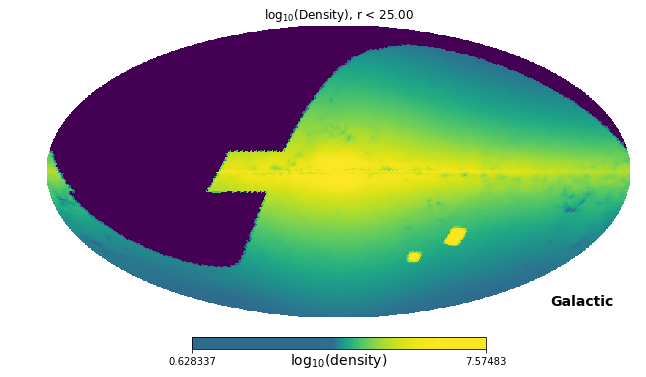

In [353]:
# density plotter moved farther down to the figure of merit plots
#
## visualize the density. I'm having difficulty getting mollview to play nice with 
## badvals (the whole upper third of the figure goes bright yellow), so here is some
## syntax to make this work a little better. 
stardensShow = np.ma.copy(stardens)
stardensShow[stardensShow.mask] = np.ma.min(stardensShow)
hp.mollview(np.log10(stardensShow), unit=r'log$_{10}$(density)', title=r'log$_{10}$(Density), %s < %.2f' % (filtDens, magdens), 
           coord=['C','G'], norm='hist')
# hp.mollview(np.log10(stardensShow), coord=['C','G'])

In [146]:
np.ma.min(stardens)

1.0

### Running the figure of merit ###

In [13]:
# let's try a few paths for comparison. These paths are currently hardwired for DATALAB.
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lShort = glob.glob('/sims_maf/fbs_1.5/short_exp/*db')
lTwilight = glob.glob('/sims_maf/*/twi*_neo/*db')
lPaths = lTwilight + lBaseline + lShort

# Note: for the full lpaths above, it takes about an hour to evaluate everything. 
# When developing, probably better to use just the first couple of entries.

## shorten the list for testing the filters
# lPaths = [lBaseline[1]] + lShort
# lPaths = lPaths[0:2]

print("Paths for opsims:")
lPaths

Paths for opsims:


['/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod1_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod2_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod3_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod4_v1.5_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern5_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern6_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern7_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_2ns_1expt_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_2ns_5expt_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_5ns_1expt_v1.

In [14]:
# Experiment with a loop through opsims
outDir = 'satur_test'
nside = 64 
timeCut=20.
# sFilter = 'r'
lFilters = ['u', 'g', 'r', 'i', 'z', 'y']
lEvals = []
plotBundles = False
for pathOpsim in lPaths:
    
    bundlesResults = {}
    for sFilter in lFilters:

        # Create and evaluate the bundle group for this run
        bgroup = evaluateBundleGroup(pathOpsim, outDir, nside, timeCut, sFilter, plotBundles)
    
        # Assess which sets to use for the saturation limit and the m5 depth 
        keySatUse, keyM5Use = selectBrightnessKeys(bgroup)
        
        # pass the appropriate bundles up for computing results
        bundlesResults[sFilter] = {'run_name':bgroup.bundleDict[keySatUse].runName, \
                              'saturation':bgroup.bundleDict[keySatUse], \
                              'm5depth':bgroup.bundleDict[keyM5Use] }
        
    # ok our list of runs should now work OK
    lEvals.append(bundlesResults)

####### INFO - run name: twilight_neo_mod1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 149540 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_u_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_u_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime < 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="u" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : u and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : u and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


####### INFO - run name: twilight_neo_mod1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="g" and visitExposureTime < 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="g" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : g and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : g and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="g" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 245150 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_g_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_g_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: twilight_neo_mod1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 374087 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_r_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_r_a

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="y" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : y and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : y and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="y" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 561776 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_y_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_y_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: twilight_neo_mod2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 148279 visits
Running:  ['twilight_neo_mod2_Median_saturation_mag_u_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod2_CoaddM5_u_a

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="r" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : r and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : r and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="i" and visitExposureTime < 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="i" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : i and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : i and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="i" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 492334 visits
Running:  ['baseline_nexp1_Median_saturation_mag_i_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_i_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="z" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 430815 visits
Running:  ['baseline_nexp1_Median_saturation_mag_z_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_z_and_visitExposur

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint filter="z" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Median saturation_mag : z and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : z and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="y" and visitExposureTime < 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Querying database SummaryAllProps with constraint filter="y" and visitExposureTime > 20.0 for columns ['skyBrightness', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'seeingFwhmEff', 'airmass', 'visitExposureTime']
Found 435014 visits
Running:  ['baseline_nexp1_Median_saturation_mag_y_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_y_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps w

INFO: twilight_neo_mod1 3545284243.546332 False 7057545025.130512 2975534536.075715 5923352690.383723
INFO: twilight_neo_mod2 5152367898.371725 False 7054420144.009546 4324349634.893404 5920729997.516856
INFO: twilight_neo_mod3 5412188902.366017 False 7055807623.505924 4542415752.438198 5921894500.241027
INFO: twilight_neo_mod4 5410092816.199871 False 7055088885.664991 4540656520.639136 5921291268.138559
INFO: twi_neo_pattern1 5145678875.113224 False 7040083157.767195 4318735580.179874 5908697056.07217
INFO: twi_neo_pattern2 5121545875.253354 False 7037301260.034121 4298480906.757604 5906362226.983174
INFO: twi_neo_pattern3 5109388489.504076 False 7040910875.970942 4288277290.1558533 5909391754.700601
INFO: twi_neo_pattern4 5082261678.66857 False 7037789626.886214 4265509930.2067676 5906772110.178668
INFO: twi_neo_pattern5 5115618091.69756 False 7038592376.531954 4293505755.6890383 5907445852.855033
INFO: twi_neo_pattern6 5111408760.679934 False 7039326813.657539 4289972890.915354 5908

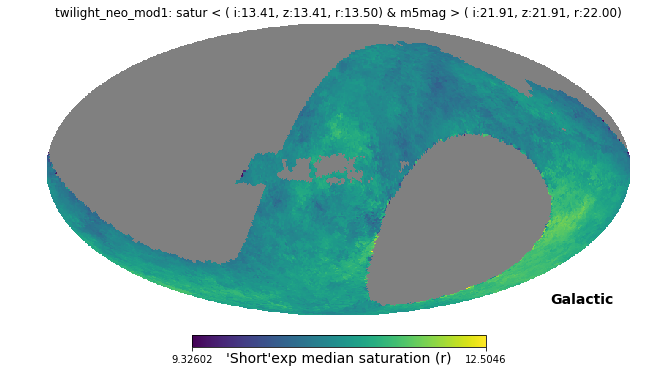

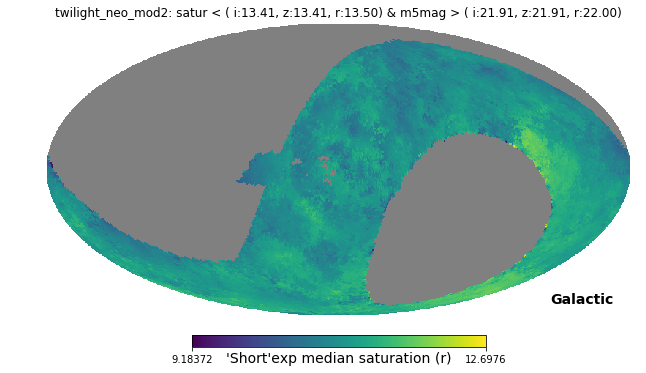

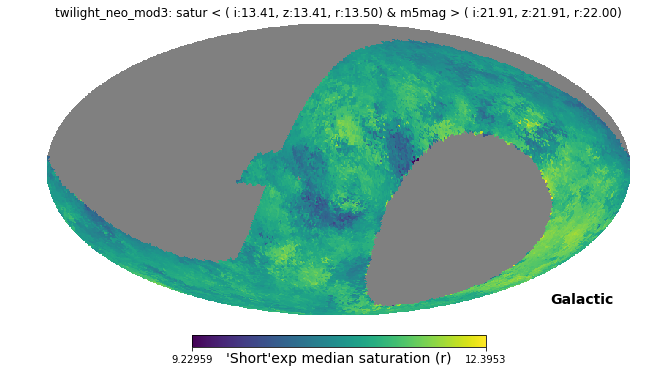

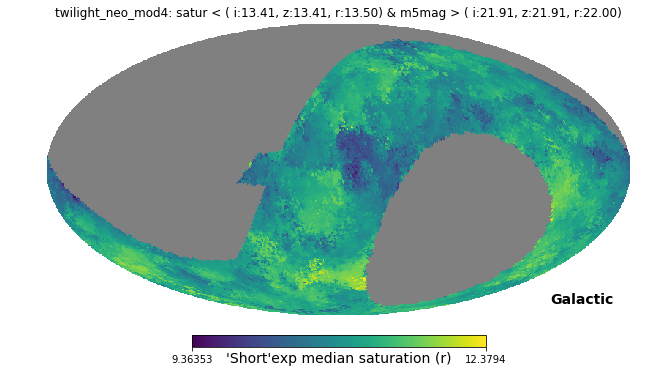

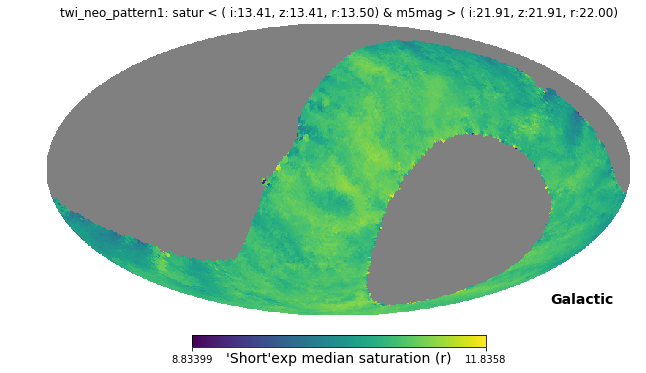

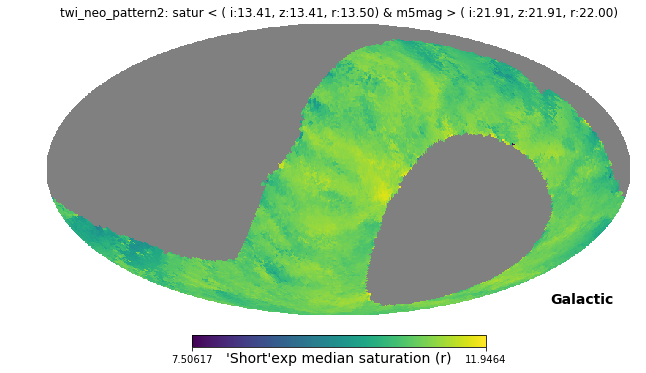

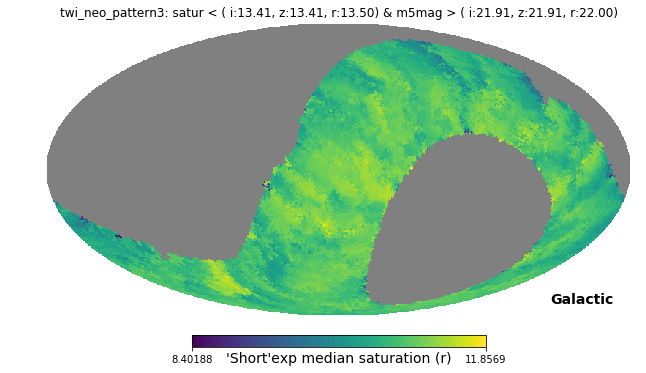

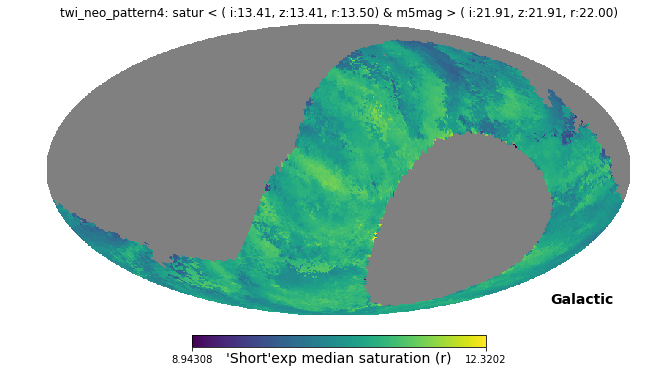

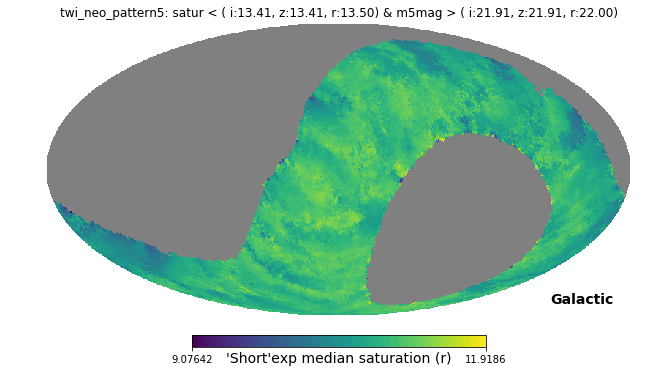

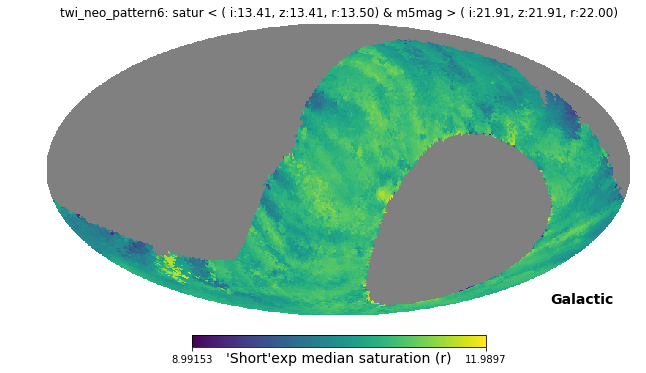

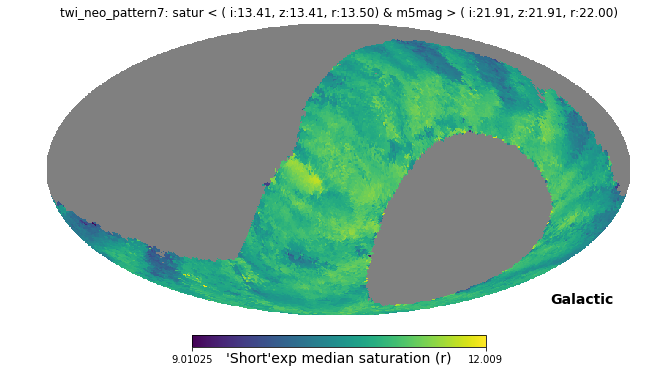

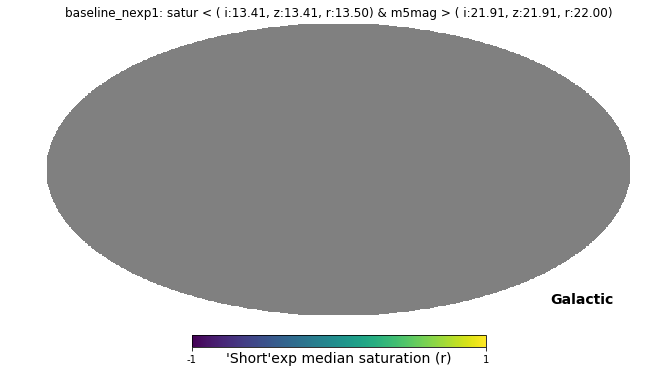

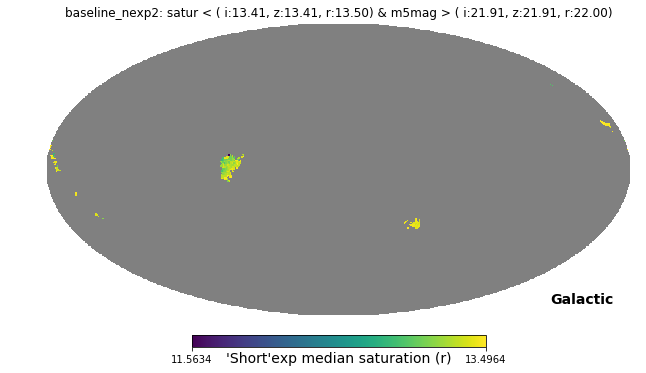

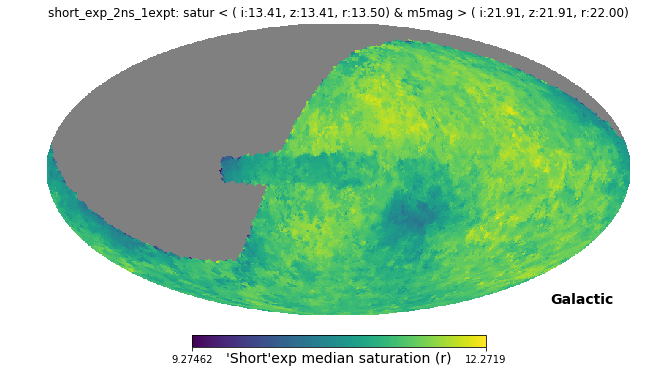

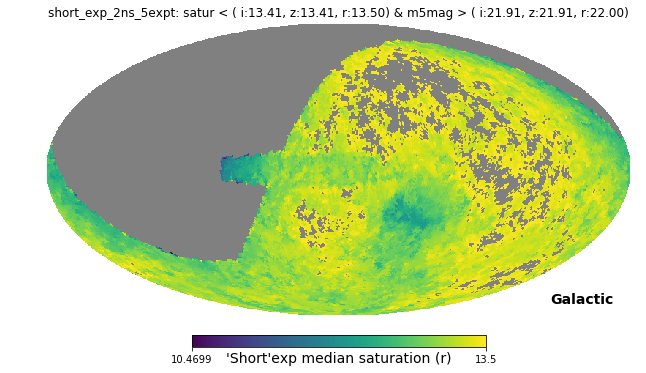

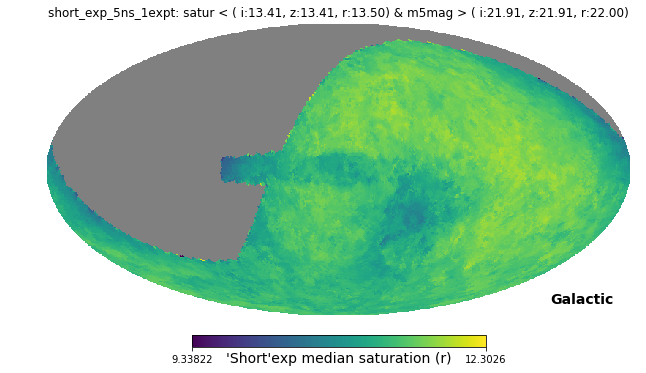

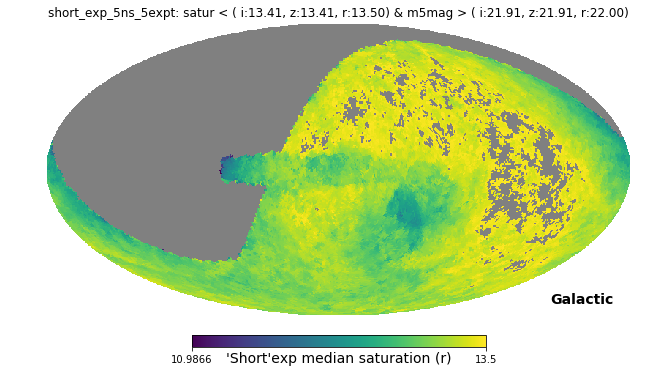

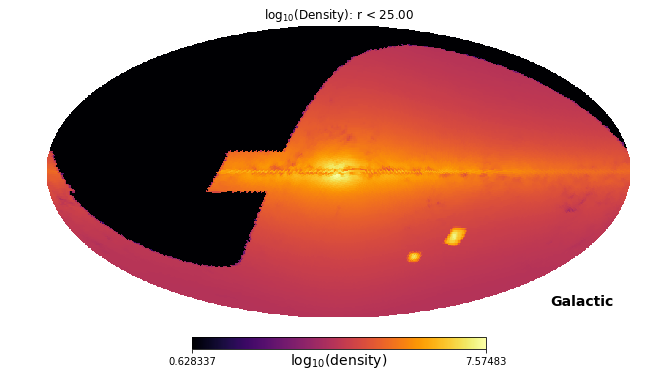

In [347]:
### Having assembled our set of bundles for the saturation and m5, now we evaluate the figure of merit
### for each run for the specified filter.
rSaturMax = 13.5
rFaintMin = 22. # set to a small number to relax the faint-limit selection
starType = 'G'

# handle star density
multiplyByDensity = True

if np.size(stardens) > 0:
    # some syntax to handle hp.mollview's treatment of masked arrays
    stardensShow = np.ma.copy(stardens)
    stardensShow[stardensShow.mask] = np.ma.min(stardensShow)
else:
    multiplyByDensity = False

# coordinate string for mollviews
sCoo = ['C','G']

# Print filter-by-filter statistics to screen?
Verbose=False

# Let's generate predicted magnitudes scaled to rband mag:
saturMags = sims_utils.stellarMags(starType, rSaturMax)
faintMags = sims_utils.stellarMags(starType, rFaintMin)

# lists of results and run names
lFoms = []    # figure of merit
lNames = []   # run names
lEithers = [] # denominator - total area observed by either long or short sets 

# filter list to evaluate. The last filter in this list is the one we'll plot.
#filtsEval = ['g', 'r', 'i']
filtsEval = ['r']
filtsEval = ['i', 'z', 'r']

# Title for the plots (so that we can use this later, outside this cell). Default in case something
# breaks in the loops.
sConds = 'Saturation bright and faint limit faint'

# healpix area for this nside
pixDeg2 = hp.nside2pixarea(nside, degrees=True)

# loop thru the opsims for which the bundles were successfully evaluated
for resDict in lEvals:

    # Don't forget to re-initialize at the start of each run...
    bMaskCombined = np.array([])
    bObservedAtall = np.array([])
    
    # Strings for plot annotations
    sSatur = 'satur < ('
    sFaint = 'm5mag > ('
    
    # loop through the filters.
    for sFilt in filtsEval:
        
        # be a bit defensive
        if not sFilt in resDict.keys():
            continue
        
        # I think the best way to apply this is to find the fields that do NOT satisfy our criteria,
        # and add them to the mask. Let's try it.
    
        # For a denominator, let's count up the non-masked fields in the "long" exposure set. We do this before
        # messing with the short-exposure mask to guard against link-versus-copy confusion.
        # nDeep = np.sum(~resDict['m5depth'].metricValues.mask)
    
        # I think we can work with only the metric values here (mollview only needs the masked array). So:
        satur = np.ma.copy(resDict[sFilt]['saturation'].metricValues)
        faint = np.ma.copy(resDict[sFilt]['m5depth'].metricValues)
        
        # What is the total area occupied by either a long or a short exposure?
        bObservedThisFilter = (~satur.mask) | (~faint.mask)
        #nEither = np.sum( (~satur.mask) | (~faint.mask) )
    
        # For which fields is the saturation limit fainter than that requested?
        bSatBad = satur > saturMags[sFilt]
        
        # for which fields is the m5 limit brighter than that requested?
        bFainBad = faint < faintMags[sFilt]
    
        # OK now we update the mask of the saturated array
        satur.soften_mask()
        satur.mask = (satur.mask) | (bSatBad) | (bFainBad)
        
        # now we combine with the master boolean
        if np.size(bMaskCombined) < 1:
            bMaskCombined = np.copy(satur.mask)
            bObservedAtall = np.copy(bObservedThisFilter)
        else:
            bMaskCombined = (bMaskCombined) | np.copy(satur.mask)
            bObservedAtall = (bObservedAtall) | (bObservedThisFilter)
    
        # Construct the title string for plots from the filters for which the saturation magnitudes
        # were populated. This could be done farther up, but this way we record the filters actually
        # used in the last successful run.
        sSatur = '%s %s:%.2f,' % (sSatur, sFilt, saturMags[sFilt])
        sFaint = '%s %s:%.2f,' % (sFaint, sFilt, faintMags[sFilt])
    
        if Verbose:
            print("PROGRESS: %s, %.2e, %.2f, %.2f" \
                  % (sFilt, np.sum(~bMaskCombined), starMags[sFilt], faintMags[sFilt]))
        
        # record the filter we're going to be plotting in the mollview - it will be the last filter
        # loop that successfully finishes.
        sUnit = "'Short'exp median saturation (%s)" % (sFilt)
                    
        # Prepare the figure title (this will need updating)
        # sConds = '%s: median sat mag < %.2f & m5mag > %.2f' % (sFilt, saturMags[sFilt], faintMin)
        
    # prepare the figure title appropriate for this opsim
    sSatur = sSatur[0:-1]+')' # replace the last ',' with ')'
    sFaint = sFaint[0:-1]+')'
    sConds = '%s & %s' % (sSatur, sFaint)
        
    # Count the number of fields that do not fail the condition...
    nNotFail = np.sum(~bMaskCombined)
    
    # ... the number of fields that were observed at all in any filter
    nEither = np.sum(bObservedAtall)
    
    # scale by star density?
    if multiplyByDensity:
        nNotFail = np.sum(stardens[~bMaskCombined])
        nEither  = np.sum(stardens[bObservedAtall])
    
    # since we're dealing with masked arrays, the result of this might be a masked value
    # if either of the sums was over entirely masked values, set to zero
    if np.ma.is_masked(nNotFail):
        nNotFail = 0.
    if np.ma.is_masked(nEither):
        nEither = 0.
    
    # ... and multiply by the healpix area. This is our figure of merit.
    areaGood = np.float(nNotFail)*pixDeg2
    areaTotal = np.float(nEither)*pixDeg2
    
    lFoms.append(areaGood)
    lNames.append(resDict[sFilt]['run_name'])
    lEithers.append(areaTotal)
    
    print("INFO:", resDict[sFilt]['run_name'], nNotFail, np.ma.is_masked(nNotFail), nEither, areaGood, areaTotal)
    
    # Before we plot, apply the cumulative mask
    satur.mask = satur.mask | bMaskCombined
    sTitle = '%s: %s' % (resDict[sFilt]['run_name'], sConds)
        
    hp.mollview(satur, unit=sUnit, title=sTitle, coord=sCoo)
 
# if we have it, show the stellar density in the same coordinate system as we chose for the mollviews
if np.size(stardens) > 0:
    hp.mollview(np.log10(stardensShow), unit=r'log$_{10}$(density)', title=r'log$_{10}$(Density): %s < %.2f' % (filtDens, magdens), 
               coord=['C','G'], cmap='inferno')


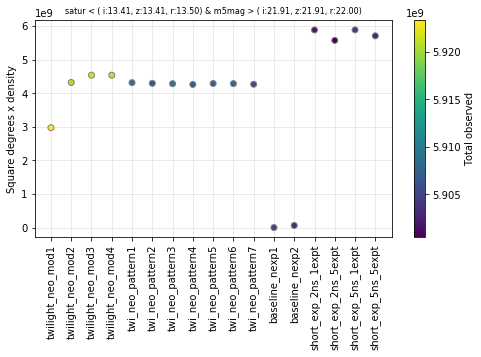

In [348]:
# suppress the offset from the colorbar and from the vertical axis
from matplotlib.ticker import ScalarFormatter
c_formatter = ScalarFormatter(useOffset=False)

# label for our axes
ylabel = 'Square degrees'

if multiplyByDensity:
    ylabel = 'Square degrees x density'

# OK now we have our figures of merit. Let's try plotting them as per Peter's Lots_of_runs.ipynb:
fig1 = plt.figure(1, figsize=(8,4))
ax1 = fig1.add_subplot(111)
x = np.arange(len(lNames))
dum = ax1.scatter(x, lFoms, c=lEithers, edgecolor='0.5', zorder=2)
ax1.set_title(sConds, fontsize=8)  # conditions label from above
ax1.yaxis.set_major_formatter(c_formatter)
ax1.set_ylabel(ylabel)
ack = plt.xticks(x, lNames, rotation=90)
cbar = fig1.colorbar(dum, ax=ax1, label='Total observed', format=c_formatter)
dum2 = ax1.grid(which='both', alpha=0.3, zorder=1)

In [17]:
# 2021-03-24 kept but commented out for the moment
#
## Define the metric bundle and the slicer
#bundleList = []

#stacker = SaturationStacker()

#sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
#metric = metrics.MedianMetric(col='saturation_mag')
#slicer = slicers.HealpixSlicer(nside=nside)
#summaryStats = [metrics.MedianMetric()]
#plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
#bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
#                                             plotDict=plotDict,
#                                             summaryMetrics=summaryStats, plotFuncs=plotFuncs,
#                                            stackerList=[stacker]))

## Now find the median depth
#metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
#bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
#                                             plotDict=plotDict, plotFuncs=plotFuncs,
#                                             summaryMetrics=summaryStats))

#sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)

#bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
##                                             plotDict=plotDict,
 #                                            summaryMetrics=summaryStats, plotFuncs=plotFuncs,
 #                                           stackerList=[stacker]))

#bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
#                                             plotDict=plotDict, plotFuncs=plotFuncs, 
#                                             summaryMetrics=summaryStats))



In [18]:
## actually run things
#bd = metricBundles.makeBundlesDictFromList(bundleList)
#bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
#bg.runAll()
#bg.plotAll(closefigs=False)

In [19]:
## use our function to determine what classes of exposure we have
#keySatUse, keyM5Use = selectBrightnessKeys(bg)
#print("INFO - saturation will use %s" % (keySatUse))
#print("INFO - m5 coadd   will use %s" % (keyM5Use))

In [20]:
## find the difference: deep coadd m5 minus median saturation level
#valuesDiffs = bg.bundleDict[keyM5Use].metricValues - bg.bundleDict[keySatUse].metricValues

In [21]:
## 2021-03-24 based on Peter's "lots of runs" ipynb, it looks like we can append the bundles into a list
## and return those to extract results. This is nice because it allows us to interrogate the metric values
## themselves if we wish (e.g. to slice again spatially or on proposalID to avoid deep drilling. In my 
## head, this makes the most sense kept as a dictionary labeled by the run name, so that there's no danger
## that the orderings of any run name list sent into the putative function, and the list of results, 
## somehow end up in different order.)

## This is the thing that a function would return, one dictionary per run.
#bundlesResults = {'run_name':run_name, 'saturation':bg.bundleDict[keySatUse], 'm5depth':bg.bundleDict[keyM5Use] }

In [22]:
### loops would end here.

# TARGET: list of run names, list of entities from which we can extract single FoMs, one per run name.

In [23]:
#print(bundlesResults)

In [24]:
## HERE IS WHERE WE SHOW THE DYNAMIC RANGE. We ought to determine how we're going 
## to encode this into a figure of merit. Since we have our metric now as Healpix
## locations, this should (!) be relatively straightforward.
#dum = hp.mollview(valuesDiffs, title='Dynamic range')

In [25]:
#!pwd

In [26]:
##utils.